# **Imports and Load data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from tqdm.notebook import tqdm, trange
from scipy.optimize import fsolve
from scipy.optimize import minimize
from google.colab import files
from tqdm.notebook import tqdm, trange

seed = 42

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('mako'))

In [2]:
!gdown 1kTwEZ937PJ8tQOL8BmxYAtQwCXyTYtzp

Downloading...
From: https://drive.google.com/uc?id=1kTwEZ937PJ8tQOL8BmxYAtQwCXyTYtzp
To: /content/uniform_data.zip
100% 5.85M/5.85M [00:00<00:00, 121MB/s]


In [3]:
!unzip 'uniform_data.zip'

Archive:  uniform_data.zip
  inflating: uniform_data_100.npy    
  inflating: uniform_data_200.npy    
  inflating: uniform_data_25.npy     
  inflating: uniform_data_400.npy    
  inflating: uniform_data_50.npy     


# **Plots Distribution**

In [ ]:
#@title Util Functions

def negative_likelihood(beta: float, data: np.ndarray):
    return - (beta * np.sum(1/data) - (1/beta) * np.sum((np.exp(beta/data) - 1)) - 2*np.sum(np.log(data)))


def log_vero(value: float, beta: float) -> float:
    return beta/value - (1/beta) * (np.exp(beta/value) - 1) - 2*np.log(value)


def Fx(x:float, beta: float) -> float:
  return np.power(np.e, 1/beta * (1 - np.power(np.e, beta/x)))


def fx(x:float, beta: float) -> float:
  return (1/np.power(x, 2)) * np.power(np.e, 1/beta * (1 - np.power(np.e, beta/x)) + beta/x)


def ppf(q: float, beta: float) -> float:
    return np.divide( beta, np.log(1 - beta * np.log(q)) )

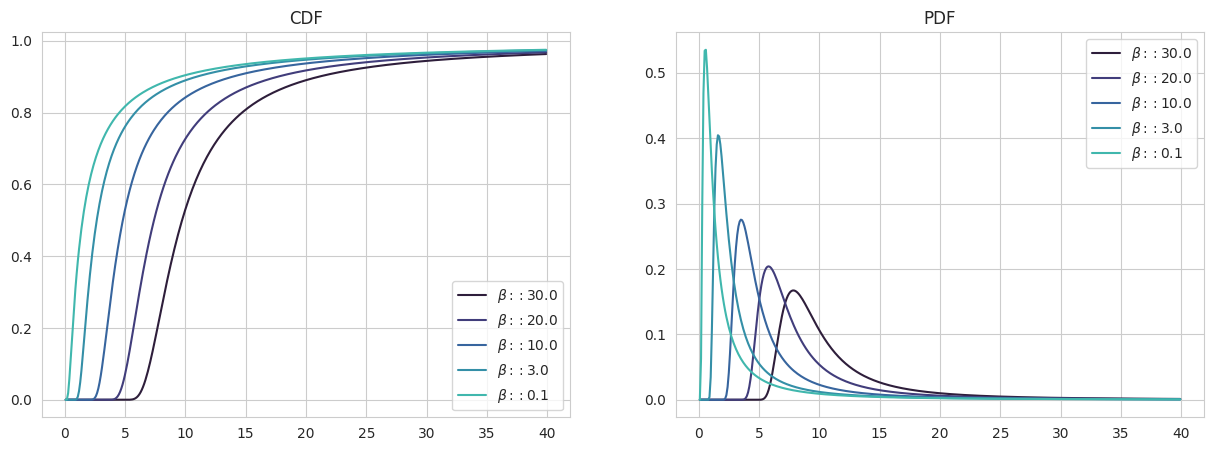

In [ ]:
betas = np.array([30, 20, 10, 3, .1])
x = np.arange(0.1, 40, 0.1)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for beta in betas:
  sns.lineplot(x=x, y=Fx(x, beta), label=r'$\beta :: $' + str(beta), ax=ax[0])
  sns.lineplot(x=x, y=fx(x, beta), label=r'$\beta :: $' + str(beta), ax=ax[1])

ax[0].set_title('CDF')
ax[1].set_title('PDF')
plt.legend()
plt.show()

# **Simulations**

In [ ]:
# Lista dos tamanhos de amostra que serão utilizados
sizes = [25, 50, 100, 200, 400]

# Dicionário para armazenar os dados carregados dos arquivos numpy.
uniform_data = {}

# Itera sobre cada tamanho de amostra na lista 'sizes'.
for size in sizes:
  # Abre o arquivo numpy correspondente ao tamanho de amostra.
  with open(f'uniform_data_{size}.npy', 'rb') as f:
    uniform_data[size] = np.load(f)

In [ ]:
#@title Classic Inference Class
class Classic:

    def __init__(self, beta: float, sizes: list,
                 uniform_data: dict):
        # Inicializa os parâmetros da classe.
        self.beta = beta
        self.sizes = sizes
        self.uniform_data = uniform_data
        self.data = {}
        self.replicas = self.uniform_data[sizes[0]].shape[0]
        self.betas_hat = {size : [] for size in self.sizes}
        self.fisher = {size : [] for size in self.sizes}
        self.statistics = {'size': [],
                           'mean': [],
                           'var': [],
                           'bias': [],
                           'MSE': [],
                           'RMSE': [],
                           'PC': []}


    @staticmethod
    def negative_likelihood(beta: float, data: np.ndarray):
        return - (beta * np.sum(1/data) - (1/beta) * np.sum((np.exp(beta/data) - 1)) - 2*np.sum(np.log(data)))


    def ppf(self, q: float) -> float:
      return np.divide(self.beta, np.log(1 - self.beta * np.log(q)))


    def fit(self, beta_guess: float = 1e-1):
        # Ajusta os parâmetros beta usando a função de verossimilhança negativa.
        for size in tqdm(self.sizes, desc='Create Estimators'):
            for data in self.uniform_data[size]:
                sample = np.array([self.ppf(q) for q in data])
                result = minimize(self.negative_likelihood, beta_guess, args=(sample,))

                # Guarda os resultados obtidos no dicionario
                self.betas_hat[size].append(result.x[0])
                self.fisher[size].append(result.hess_inv[0][0])


    def create_statistics(self, alpha: float = 5e-2):

        z = stats.norm.ppf(1 - (alpha/2))

        for key in self.betas_hat:

            # Cria estatísticas com base nos resultados da estimação.
            data = np.array(self.betas_hat[key])

            self.statistics['size'].append(key)
            self.statistics['mean'].append(np.mean(data))
            self.statistics['var'].append(np.var(data))
            self.statistics['bias'].append(np.mean(data) - self.beta)
            MSE = np.sum((self.beta - data)**2) / len(data)
            self.statistics['MSE'].append(MSE)
            self.statistics['RMSE'].append(np.sqrt(MSE))

            cout = 0
            for current_beta, variance in zip(data, self.fisher[key]):
                upper = current_beta  + z * np.sqrt(variance)
                lower = current_beta  - z * np.sqrt(variance)

                cout += 1 if lower < self.beta < upper else 0

            self.statistics['PC'].append(cout / self.replicas)

        self.statistics = pd.DataFrame(self.statistics)

## **Example**

In [ ]:
beta = .4

exp = Classic(beta, [25, 50, 100, 200, 400], uniform_data)
exp.fit()
print(f'Beta :: {beta}')
exp.create_statistics()
print(exp.statistics)
print('=' * 60)

Create Estimators:   0%|          | 0/5 [00:00<?, ?it/s]

Beta :: 0.4
   size      mean       var      bias       MSE      RMSE     PC
0    25  0.494617  0.061564  0.094617  0.070517  0.265550  0.932
1    50  0.451536  0.028816  0.051536  0.031472  0.177404  0.938
2   100  0.421719  0.011108  0.021719  0.011579  0.107608  0.950
3   200  0.412070  0.005389  0.012070  0.005535  0.074395  0.948
4   400  0.406902  0.002640  0.006902  0.002688  0.051844  0.942


## **Running simulations**

In [ ]:
sizes = np.array([25, 50, 100, 200, 400], dtype=int)
betas = [.125, .6, 1]

for beta in betas:
  exp = Classic(beta, sizes, uniform_data)
  exp.fit()
  print(f'Beta :: {beta}')
  exp.create_statistics()
  print(exp.statistics)
  print('=' * 60)

Create Estimators:   0%|          | 0/5 [00:00<?, ?it/s]

Beta :: 0.125
   size      mean       var      bias       MSE      RMSE     PC
0    25  0.214629  0.044276  0.089629  0.052309  0.228712  0.933
1    50  0.173871  0.019995  0.048871  0.022384  0.149612  0.935
2   100  0.145898  0.007447  0.020898  0.007884  0.088791  0.945
3   200  0.136500  0.003540  0.011500  0.003672  0.060599  0.947
4   400  0.131363  0.001713  0.006363  0.001754  0.041880  0.948


Create Estimators:   0%|          | 0/5 [00:00<?, ?it/s]

Beta :: 0.6
   size      mean       var      bias       MSE      RMSE     PC
0    25  0.698618  0.074206  0.098618  0.083932  0.289710  0.932
1    50  0.653746  0.035250  0.053746  0.038139  0.195292  0.940
2   100  0.622565  0.013778  0.022565  0.014287  0.119529  0.951
3   200  0.612607  0.006740  0.012607  0.006899  0.083057  0.949
4   400  0.607330  0.003317  0.007330  0.003370  0.058056  0.946


Create Estimators:   0%|          | 0/5 [00:00<?, ?it/s]

Beta :: 1
   size      mean       var      bias       MSE      RMSE     PC
0    25  1.106558  0.100101  0.106558  0.111455  0.333849  0.932
1    50  1.058147  0.048430  0.058147  0.051811  0.227621  0.941
2   100  1.024350  0.019263  0.024350  0.019856  0.140910  0.954
3   200  1.013706  0.009520  0.013706  0.009708  0.098527  0.948
4   400  1.008151  0.004709  0.008151  0.004775  0.069105  0.946


# **Using article data**

In [ ]:
#@title A Distribution
def A_distribution(x_values, **kwargs):

    def MLE_A(x_values, **kwargs):
        initial_guess = kwargs['initial_guess']
        def estimator(beta):
            sum_X = sum(x**-1 for x in x_values)
            sum_numerator = sum(((beta/x) * np.exp(beta/x)) - np.exp(beta/x) + 1 for x in x_values)
            return sum_X - sum_numerator / (beta**2)

        result = fsolve(func=estimator, x0=initial_guess, xtol = 1e-7, maxfev = 1000)
        return result[0]

    def LL_A(x_values, **kwargs):
        beta_hat = kwargs['beta_hat']

        sum_X =   sum(x**-1 for x in x_values)
        sum_numerator = sum(np.exp(beta_hat/x) - 1 for x in x_values)
        sum_ln = sum(np.log(x) for x in x_values)
        return (beta_hat * sum_X) - (sum_numerator / beta_hat) - (2 * sum_ln)

    results_mle = []
    results_ll = []
    # Caso que envolve resolução por métodos numéricos - vários tamanhos de passos/repetições para checar convergência
    for i in range(1, 1000, 100):
        for j in range(5):
            results_mle.append(MLE_A(sample, initial_guess = i))
            b_hat = sum(results_mle) / len(results_mle)
            results_ll.append(LL_A(sample, beta_hat = b_hat))

    # Checando a diferença máxima entro os valores gerados:
    tol = 1e-7
    diff_mle = 0
    diff_ll = 0
    for i in range(len(results_mle)):
        for j in range(i + 1, len(results_mle)):
            diff = abs(results_mle[i] - results_mle[j])
            if diff > diff_mle:
                diff_mle = diff

            diff = abs(results_ll[i] - results_ll[j])
            if diff > diff_ll:
                diff_ll = diff

    if (diff_mle > tol) or (diff_ll > tol):
        print("Erro de convergência!\nFunção abortada!")
        return None

    mle = results_mle[0]
    ll = results_ll[0]

    def CDF(x):
        result = np.zeros_like(x)
        mask_positive = x > 0

        c = mle / x[mask_positive]
        log_cdf = (1 - np.exp(c)) / mle
        result[mask_positive] = np.exp(log_cdf)
        return result

    def PDF(x):
        result = np.zeros_like(x)
        mask_positive = x > 0

        c = mle / x[mask_positive]
        result[mask_positive] = (x**-2) * np.exp(((1 - np.exp(c))/mle) + c)
        return result

    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    ks_test = stats.kstest(x_values, CDF)
    return ['A', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

In [ ]:
#@title Other Distributions
def get_stats(x_values, loglike):
    AIC = 2 - 2*loglike
    BIC = np.log(len(x_values)) - 2*loglike
    CAIC = AIC + (4/len(x_values))
    HQIC = -2*loglike + 2*np.log(np.log(len(x_values)))

    return AIC, CAIC, BIC, HQIC

def Exponencial(x_values, **kwargs):
    mle = len(x_values) / sum(x_values)
    ll = len(x_values)*np.log(mle) - np.sum(x_values)*mle
    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    def CDF(x):
        cdf = 1 - np.exp(-mle*x)
        return cdf

    def PDF(x):
        pdf = mle * np.exp(-mle*x)
        return pdf

    ks_test = stats.kstest(x_values, CDF)
    return ['Exponencial', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

def Inverse_Exponencial(x_values, **kwargs):
    mle = len(x_values) / sum(x**-1 for x in x_values)
    ll = len(x_values) * np.log(mle) - 2  * np.sum(np.log(x_values))  - mle*sum(x**-1 for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    def CDF(x):
        cdf = np.exp(-mle/x)
        return cdf

    def PDF(x):
        pdf = mle * np.exp(-mle/x) / (x**2)
        return pdf

    ks_test = stats.kstest(x_values, CDF)
    return ['Inverse Exponencial', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

def Lindley(x_values, **kwargs):
    mean = sum(x_values) / len(x_values)
    mle = (((mean - 1)**2 + 8*mean)**.5 - (mean - 1)) / (2*mean)
    ll = len(x_values) * (2 * np.log(mle) - np.log(1 + mle)) - mle*np.sum(x_values) + sum(np.log(1 + x) for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    def CDF(x):
        cdf = 1 - ((1 + mle + mle*x) / (1 + mle)) * np.exp(-mle * x)
        return cdf

    def PDF(x):
        pdf = (np.exp(-mle*x) * (x * mle**2 + mle**2)) / (mle + 1)
        return pdf

    ks_test = stats.kstest(x_values, CDF)
    return ['Lindley', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])


def Rayleigh(x_values, **kwargs):
    mle = len(x_values) / (sum(x**2 for x in x_values))
    ll = len(x_values) * np.log(2*mle)  +  np.sum(np.log(x_values)) - mle * sum(x**2 for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    def CDF(x):
        cdf = 1 - np.exp(-mle*(x**2))
        return cdf

    def PDF(x):
        pdf = 2 * mle * x * np.exp(-mle*(x**2))
        return pdf

    ks_test = stats.kstest(x_values, CDF)
    return ['Rayleigh', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])


def Inverse_Rayleigh(x_values, **kwargs):
    mle = len(x_values) / sum(x**-2 for x in x_values)
    ll = len(x_values) * np.log(2*mle)  - 3 * np.sum(np.log(x_values)) - mle * sum(x**-2 for x in x_values)
    sample_cont = np.linspace(min(x_values), max(x_values), 100)

    def CDF(x):
        cdf = np.exp(-mle/(x**2))
        return cdf

    def PDF(x):
        pdf = 2 * mle * np.exp(-mle/(x**2)) / (x**3)
        return pdf

    ks_test = stats.kstest(x_values, CDF)
    return ['Inverse Rayleigh', mle, -ll, ks_test.statistic, ks_test.pvalue, *get_stats(x_values, ll)], (sample_cont, [CDF(x) for x in sample_cont], [PDF(x) for x in sample_cont])

In [ ]:
sample = np.array([ 18.83 , 20.8 , 21.657 , 23.03 , 23.23 , 24.05 , 24.321 , 25.5 , 25.52 , 25.8 , 26.69 ,
                    26.77 , 26.78 , 27.05 , 27.67 , 29.9 , 31.11 , 33.2 , 33.73 , 33.76 , 33.89 , 34.76 ,
                    35.75 , 35.91 , 36.98 , 37.08 , 37.09 , 39.58 , 44.045 , 45.29 , 45.381 ])

In [ ]:
df_stats = pd.DataFrame(columns = ['Distribution', 'MLE', '-LL', 'KS_stat', 'KS_p', 'AIC', 'CAIC', 'BIC', 'HQIC'])
results_mle = []
results_ll = []

In [ ]:
df_stats.loc[len(df_stats)], cdf_exp = Exponencial(sample)
df_stats.loc[len(df_stats)], cdf_invexp = Inverse_Exponencial(sample)
df_stats.loc[len(df_stats)], cdf_lind = Lindley(sample)
df_stats.loc[len(df_stats)], cdf_ray = Rayleigh(sample)
df_stats.loc[len(df_stats)], cdf_invray = Inverse_Rayleigh(sample)
df_stats.loc[len(df_stats)], cdf_A = A_distribution(sample)

df_stats

,Distribution,MLE,-LL,KS_stat,KS_p,AIC,CAIC,BIC,HQIC
0,Exponencial,0.032455,137.264447,0.458623,1.748867e-06,276.528894,276.657926,277.962881,276.996338
1,Inverse Exponencial,29.215334,137.261497,0.474696,6.155969e-07,276.522995,276.652027,277.956982,276.990439
2,Lindley,0.062988,126.994191,0.365453,3.219054e-04,255.988382,256.117414,257.422369,256.455826
3,Rayleigh,0.001000,118.222345,0.318876,2.651648e-03,238.444691,238.573723,239.878678,238.912135
4,Inverse Rayleigh,810.503208,118.200626,0.325347,2.015911e-03,238.401253,238.530285,239.835240,238.868697
5,A,125.662000,107.950308,0.161626,3.543295e-01,217.900616,218.029648,219.334603,218.368060


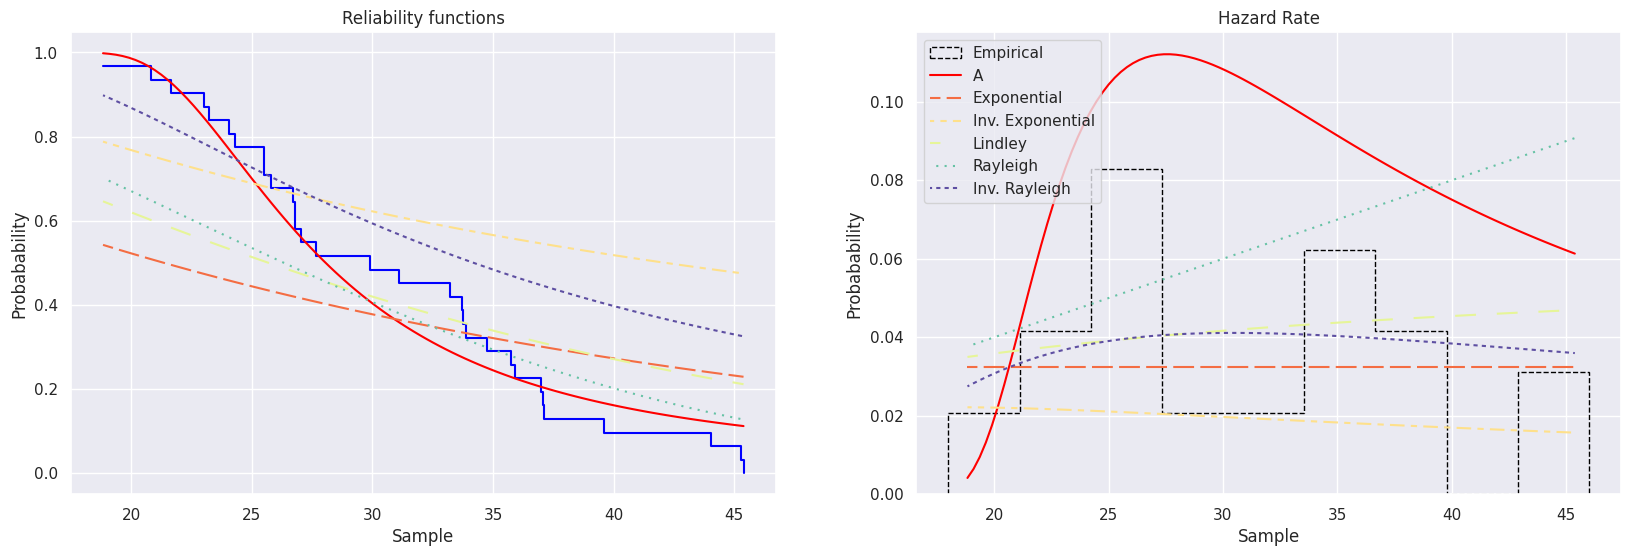

In [ ]:
prob_empirica = np.arange(1, len(sample) + 1) / len(sample)
sample_space = np.linspace(min(sample), max(sample), 150)

patt = plt.get_cmap('Spectral', 6)

fig, axs = plt.subplots(1, 2, figsize = (20,6))

ax = axs[0]
ax.step(sample, 1 - prob_empirica, where='post',  color = 'blue', label = 'Empirical')
ax.plot(cdf_A[0], [1 - x for x in cdf_A[1]], color = 'red', label = 'A')
ax.plot(cdf_exp[0], [1 - x for x in cdf_exp[1]], ls = (5, (10, 3)), color = patt(1), label = 'Exponential')
ax.plot(cdf_invexp[0], [1 - x for x in cdf_invexp[1]], ls = (5, (7, 3, 3, 3)), color = patt(2), label = 'Inv. Exponential')
ax.plot(cdf_lind[0], [1 - x for x in cdf_lind[1]], ls = (5, (10, 10)), color = patt(3), label = 'Lindley')
ax.plot(cdf_ray[0], [1 - x for x in cdf_ray[1]], ls = (5, (1, 3)), color = patt(4), label = 'Rayleigh')
ax.plot(cdf_invray[0], [1 - x for x in cdf_invray[1]], ls = (5, (2, 2)), color = patt(5), label = 'Inv. Rayleigh')

ax.set_xlabel('Sample')
ax.set_ylabel('Probabability')
ax.set_title('Reliability functions')

ax = axs[1]

bin_edges = np.linspace(18, 46, 10)

ax.hist(sample, bins = bin_edges, density = True, histtype='step', edgecolor='black', linestyle='dashed', label = 'Empirical')
ax.plot(cdf_A[0], [x/(1-y) for x, y in zip(cdf_A[2], cdf_A[1])], color = 'red', label = 'A')
ax.plot(cdf_exp[0], [x/(1-y) for x, y in zip(cdf_exp[2], cdf_exp[1])], ls = (5, (10, 3)), color = patt(1), label = 'Exponential')
ax.plot(cdf_invexp[0], [x/(1-y) for x, y in zip(cdf_invexp[2], cdf_invexp[1])], ls = (5, (7, 3, 3, 3)), color = patt(2), label = 'Inv. Exponential')
ax.plot(cdf_lind[0], [x/(1-y) for x, y in zip(cdf_lind[2], cdf_lind[1])], ls = (5, (10, 10)), color = patt(3), label = 'Lindley')
ax.plot(cdf_ray[0], [x/(1-y) for x, y in zip(cdf_ray[2], cdf_ray[1])], ls = (5, (1, 3)), color = patt(4), label = 'Rayleigh')
ax.plot(cdf_invray[0], [x/(1-y) for x, y in zip(cdf_invray[2], cdf_invray[1])], ls = (5, (2, 2)), color = patt(5), label = 'Inv. Rayleigh')

ax.set_xlabel('Sample')
ax.set_ylabel('Probabability')
ax.set_title('Hazard Rate')


plt.legend()
plt.grid(True)
plt.show()

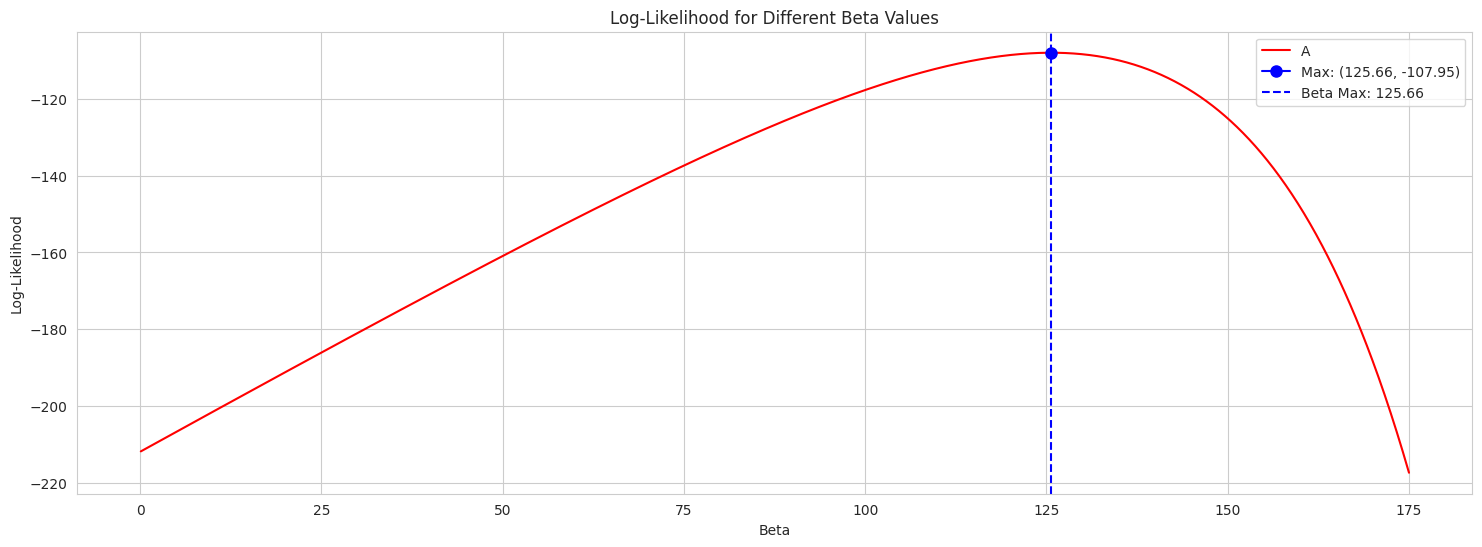

In [ ]:
def LL_A(beta_hat, x_values, **kwargs):
    sum_X = sum(x**-1 for x in x_values)
    sum_numerator = sum(np.exp(beta_hat/x) - 1 for x in x_values)
    sum_ln = sum(np.log(x) for x in x_values)
    ll = (beta_hat * sum_X) - (sum_numerator / beta_hat) - (2 * sum_ln)
    return ll


beta = np.linspace(0.1, 175, 2500)
ll_values = [LL_A(beta_hat, sample) for beta_hat in beta]

max_index = np.argmax(ll_values)
max_beta = beta[max_index]
max_ll = ll_values[max_index]

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax.plot(beta, ll_values, color='red', label='A')

ax.plot(max_beta, max_ll, marker='o', markersize=8, color='blue', label=f'Max: ({max_beta:.2f}, {max_ll:.2f})')
ax.axvline(x=max_beta, color='blue', linestyle='--', label=f'Beta Max: {max_beta:.2f}')

ax.set_xlabel('Beta')
ax.set_ylabel('Log-Likelihood')
ax.set_title('Log-Likelihood for Different Beta Values')
ax.legend()
plt.show()
